## sEEG data

In [1]:
import numpy as np

import mne
from mne.datasets import fetch_fsaverage

# paths to mne datasets - sample sEEG and FreeSurfer's fsaverage subject
# which is in MNI space
misc_path = mne.datasets.misc.data_path()
sample_path = mne.datasets.sample.data_path()
subjects_dir = sample_path / 'subjects'

# use mne-python's fsaverage data
fetch_fsaverage(subjects_dir=subjects_dir, verbose=True)  # downloads if needed

0 files missing from root.txt in /Users/DanDan/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/DanDan/mne_data/MNE-sample-data/subjects/fsaverage


'/Users/DanDan/mne_data/MNE-sample-data/subjects/fsaverage'

In [2]:
raw = mne.io.read_raw(misc_path / 'seeg' / 'sample_seeg_ieeg.fif')

events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, event_id, detrend=1, baseline=None)
epochs = epochs['Response'][0]  # just process one epoch of data for speed

Opening raw data file /Users/DanDan/mne_data/MNE-misc-data/seeg/sample_seeg_ieeg.fif...
    Range : 1310640 ... 1370605 =   1311.411 ...  1371.411 secs
Ready.
Used Annotations descriptions: ['Fixation', 'Go Cue', 'ISI Onset', 'Response']
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated


In [3]:
montage = epochs.get_montage()

# first we need a head to mri transform since the data is stored in "head"
# coordinates, let's load the mri to head transform and invert it
this_subject_dir = misc_path / 'seeg'
head_mri_t = mne.coreg.estimate_head_mri_t('sample_seeg', this_subject_dir)
# apply the transform to our montage
montage.apply_trans(head_mri_t)

# now let's load our Talairach transform and apply it
mri_mni_t = mne.read_talxfm('sample_seeg', misc_path / 'seeg')
montage.apply_trans(mri_mni_t)  # mri to mni_tal (MNI Taliarach)

# for fsaverage, "mri" and "mni_tal" are equivalent and, since
# we want to plot in fsaverage "mri" space, we need use an identity
# transform to equate these coordinate frames
montage.apply_trans(
    mne.transforms.Transform(fro='mni_tal', to='mri', trans=np.eye(4)))

epochs.set_montage(montage)

Number of events,1
Events,Response: 1
Time range,-0.200 – 0.500 sec
Baseline,off


In [4]:
# compute the transform to head for plotting
trans = mne.channels.compute_native_head_t(montage)
# note that this is the same as:
# ``mne.transforms.invert_transform(
#      mne.transforms.combine_transforms(head_mri_t, mri_mni_t))``

fig = mne.viz.plot_alignment(epochs.info, trans, 'fsaverage',
                             subjects_dir=subjects_dir, show_axes=True,
                             surfaces=['pial', 'head'], coord_frame='mri')

Using pyvistaqt 3d backend.

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Using outer_skin.surf for head surface.
Channel types::	seeg: 119


Electrodes in the dataset: {'LPIT', 'LPLI', 'LTPO', 'LENT', 'LBRI', 'LSMA', 'LPM', 'RAHP', 'LPCN', 'LAMY', 'LOFC', 'RPHP', 'LPHG', 'LACN', 'LSTG'}


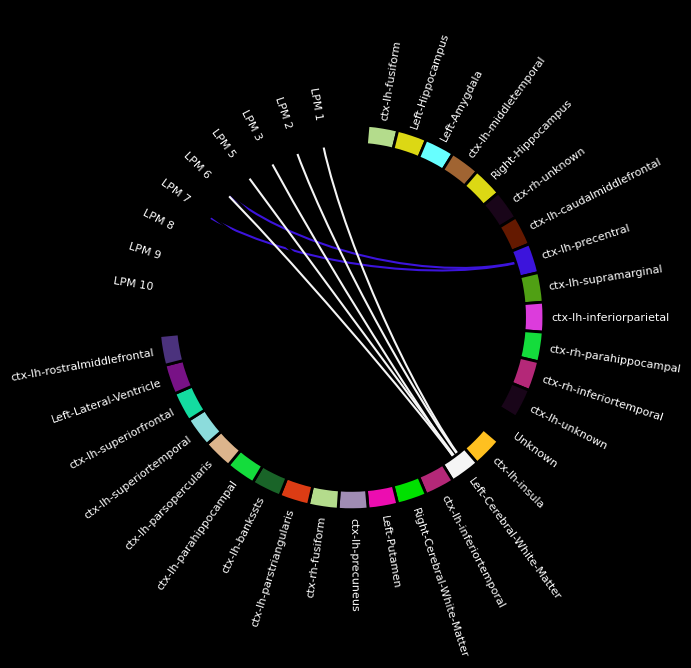

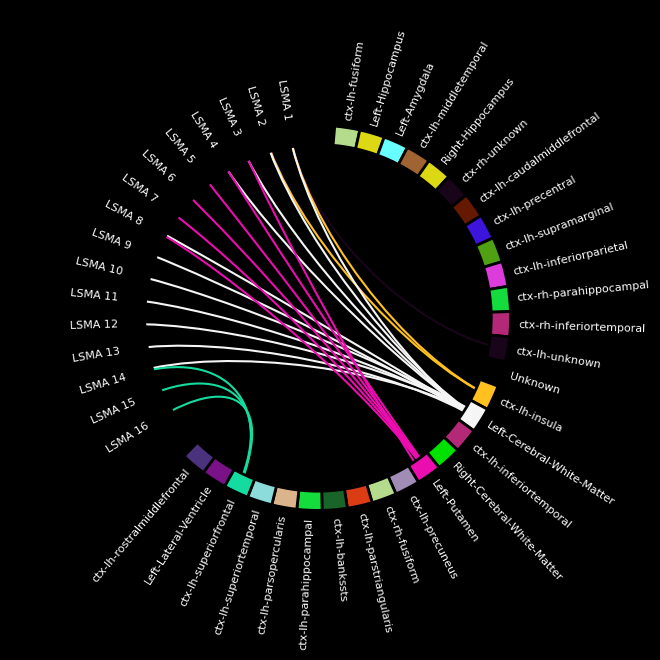

In [5]:
aseg = 'aparc+aseg'  # parcellation/anatomical segmentation atlas
labels, colors = mne.get_montage_volume_labels(
    montage, 'fsaverage', subjects_dir=subjects_dir, aseg=aseg)

# separate by electrodes which have names like LAMY 1
electrodes = set([''.join([lttr for lttr in ch_name
                           if not lttr.isdigit() and lttr != ' '])
                  for ch_name in montage.ch_names])
print(f'Electrodes in the dataset: {electrodes}')

electrodes = ('LPM', 'LSMA')  # choose two for this example
for elec in electrodes:
    picks = [ch_name for ch_name in epochs.ch_names if elec in ch_name]
    fig, ax = mne.viz.plot_channel_labels_circle(labels, colors, picks=picks)
    fig.text(0.3, 0.9, 'Anatomical Labels', color='white')

In [6]:
picks = [ii for ii, ch_name in enumerate(epochs.ch_names) if
         any([elec in ch_name for elec in electrodes])]
labels = ('ctx-lh-caudalmiddlefrontal', 'ctx-lh-precentral',
          'ctx-lh-superiorfrontal', 'Left-Putamen')

fig = mne.viz.plot_alignment(mne.pick_info(epochs.info, picks), trans,
                             'fsaverage', subjects_dir=subjects_dir,
                             surfaces=[], coord_frame='mri')

brain = mne.viz.Brain('fsaverage', alpha=0.1, cortex='low_contrast',
                      subjects_dir=subjects_dir, units='m', figure=fig)
brain.add_volume_labels(aseg='aparc+aseg', labels=labels)
brain.show_view(azimuth=120, elevation=90, distance=0.25)

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Channel types::	seeg: 25
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
    Smoothing by a factor of 0.9


Loading data for 1 events and 701 original time points ...


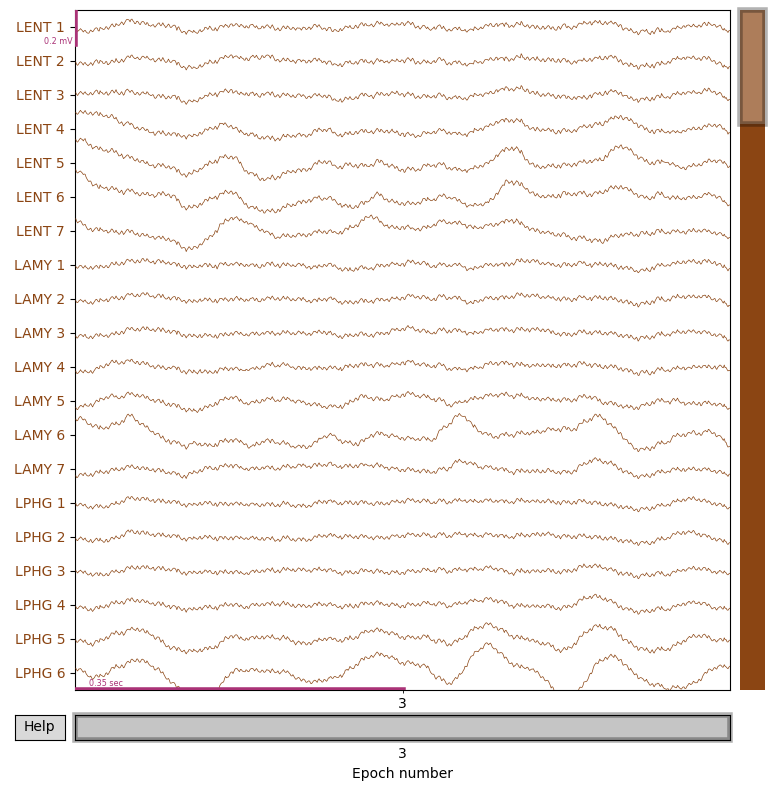

In [8]:
epochs.plot();

In [9]:
# get standard fsaverage volume (5mm grid) source space
fname_src = (subjects_dir / 'fsaverage' / 'bem' /
             'fsaverage-vol-5-src.fif')
vol_src = mne.read_source_spaces(fname_src)

evoked = epochs.average()
stc = mne.stc_near_sensors(
    evoked, trans, 'fsaverage', subjects_dir=subjects_dir, src=vol_src,
    verbose='error')  # ignore missing electrode warnings
stc = abs(stc)  # just look at magnitude
clim = dict(kind='value', lims=np.percentile(abs(evoked.data), [10, 50, 75]))

    Reading a source space...
    [done]
    1 source spaces read


In [10]:
brain = stc.plot_3d(
    src=vol_src, subjects_dir=subjects_dir,
    view_layout='horizontal', views=['axial', 'coronal', 'sagittal'],
    size=(800, 300), show_traces=0.4, clim=clim,
    add_data_kwargs=dict(colorbar_kwargs=dict(label_font_size=8)))

# You can save a movie like the one on our documentation website with:
# brain.save_movie(time_dilation=3, interpolation='linear', framerate=5,
#                  time_viewer=True, filename='./mne-test-seeg.m4')

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


Traceback (most recent call last):
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py", line 2298, in save
    format = EXTENSION[ext]
KeyError: ''

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 1135, in save_image
    self.save_image(filename)
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_brain/_brain.py", line 3016, in save_image
    _save_ndarray_img(
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py", line 2430, in _save_ndarray_img
    Image.fromarray(img).save(fname)
  File "/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py", line 2300, in save
    raise ValueError(f"unknown file extension: {ext}") from e
ValueError: unknown file extension: 
/Users/DanDan/opt/anaconda3/lib/python3.9/site-packages/pyvistaqt/dialog.py:74: Runtim

## working with ECoG data

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mne_bids import BIDSPath, read_raw_bids

import mne
from mne.viz import plot_alignment, snapshot_brain_montage

print(__doc__)

# paths to mne datasets - sample ECoG and FreeSurfer subject
bids_root = mne.datasets.epilepsy_ecog.data_path()
sample_path = mne.datasets.sample.data_path()
subjects_dir = sample_path / 'subjects'

Automatically created module for IPython interactive environment
Using default location ~/mne_data for epilepsy_ecog...


100%|█████████████████████████████████████| 88.2M/88.2M [00:00<00:00, 88.2GB/s]
Untarring contents of '/Users/DanDan/mne_data/MNE-epilepsy-ecog-data.tar.gz' to '/Users/DanDan/mne_data'


In [16]:
# first define the bids path
bids_path = BIDSPath(root=bids_root, subject='pt1', session='presurgery',
                     task='ictal', datatype='ieeg', extension='.vhdr')

# then we'll use it to load in the sample dataset
# Here we use a format (iEEG) that is only available in MNE-BIDS 0.7+, so it
# will emit a warning on versions <= 0.6
raw = read_raw_bids(bids_path=bids_path, verbose=False)

# Pick only the ECoG channels, removing the EKG channels
raw.pick_types(ecog=True)

# Load the data
raw.load_data()

# Then we remove line frequency interference
raw.notch_filter([60], trans_bandwidth=3)

# drop bad channels
raw.drop_channels(raw.info['bads'])

# the coordinate frame of the montage
montage = raw.get_montage()
print(montage.get_positions()['coord_frame'])

# add fiducials to montage
montage.add_mni_fiducials(subjects_dir)

# now with fiducials assigned, the montage will be properly converted
# to "head" which is what MNE requires internally (this is the coordinate
# system with the origin between LPA and RPA whereas MNI has the origin
# at the posterior commissure)
raw.set_montage(montage)

# Find the annotated events
events, event_id = mne.events_from_annotations(raw)

# Make a 25 second epoch that spans before and after the seizure onset
epoch_length = 25  # seconds
epochs = mne.Epochs(raw, events, event_id=event_id['onset'],
                    tmin=13, tmax=13 + epoch_length, baseline=None)
# Make evoked from the one epoch and resample
evoked = epochs.average().resample(200)
del epochs

Reading 0 ... 269079  =      0.000 ...   269.079 secs...


/var/folders/gy/vmc0g_m96tvb6cdgrbz7478r0000gn/T/ipykernel_5614/3625301323.py:8: RuntimeWarning: DigMontage is only a subset of info. There are 3 channel positions not present in the DigMontage. The required channels are:

['RQ1', 'RQ2', 'N/A'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Setting up band-stop filter from 58 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 58.35
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 57.60 Hz)
- Upper passband edge: 61.65 Hz
- Upper transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 62.40 Hz)
- Filter length: 2201 samples (2.201 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    1.2s finished


mni_tal
Used Annotations descriptions: ['AD1-4, ATT1,2', 'AST1,3', 'G16', 'PD', 'SLT1-3', 'offset', 'onset']
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


In [17]:
fig = plot_alignment(raw.info, trans='fsaverage',
                     subject='fsaverage', subjects_dir=subjects_dir,
                     surfaces=['pial'], coord_frame='head')
mne.viz.set_3d_view(fig, azimuth=0, elevation=70)

xy, im = snapshot_brain_montage(fig, raw.info)

For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Channel types::	ecog: 84
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`


In [ ]:
# compute frequency features of the data
# signal power in the gamma(30 -90 hz) band, downsampling the result to 10 hz

In [18]:
sfreq = 10
gamma_power_t = evoked.copy().filter(30, 90).apply_hilbert(
    envelope=True).resample(sfreq)
gamma_info = gamma_power_t.info

Setting up band-pass filter from 30 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 95.00 Hz)
- Filter length: 89 samples (0.445 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.2s finished


In [19]:
# convert from a dictionary to array to plot
xy_pts = np.vstack([xy[ch] for ch in raw.info['ch_names']])

# get a colormap to color nearby points similar colors
cmap = plt.colormaps['viridis']

# create the figure of the brain with the electrode positions
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Gamma power over time', size='large')
ax.imshow(im)
ax.set_axis_off()

# normalize gamma power for plotting
gamma_power = -100 * gamma_power_t.data / gamma_power_t.data.max()
# add the time course overlaid on the positions
x_line = np.linspace(-0.025 * im.shape[0], 0.025 * im.shape[0],
                     gamma_power_t.data.shape[1])
for i, pos in enumerate(xy_pts):
    x, y = pos
    color = cmap(i / xy_pts.shape[0])
    ax.plot(x_line + x, gamma_power[i] + y, linewidth=0.5, color=color)

In [20]:
xyz_pts = np.array([dig['r'] for dig in evoked.info['dig']])

src = mne.read_source_spaces(subjects_dir / 'fsaverage' / 'bem' /
                             'fsaverage-ico-5-src.fif')
stc = mne.stc_near_sensors(gamma_power_t, trans='fsaverage',
                           subject='fsaverage', subjects_dir=subjects_dir,
                           src=src, surface='pial', mode='nearest',
                           distance=0.02)
vmin, vmid, vmax = np.percentile(gamma_power_t.data, [10, 25, 90])
clim = dict(kind='value', lims=[vmin, vmid, vmax])
brain = stc.plot(surface='pial', hemi='rh', colormap='inferno', colorbar=False,
                 clim=clim, views=['lat', 'med'], subjects_dir=subjects_dir,
                 size=(250, 250), smoothing_steps='nearest',
                 time_viewer=False)
brain.add_sensors(raw.info, trans='fsaverage')
del brain

# You can save a movie like the one on our documentation website with:
# brain.save_movie(time_dilation=1, interpolation='linear', framerate=3,
#                  time_viewer=True)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Projecting data from 84 sensors onto 20484 surface vertices: nearest mode
    Projecting sensors onto surface
    Minimum projected intra-sensor distance: 2.3 mm
    4932 / 20484 non-zero vertices
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Channel types::	ecog: 84
Channel types::	ecog: 84


## sleep stage classification from polysomnography (PSG) data

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

Using default location ~/mne_data for PHYSIONET_SLEEP...


Extracting EDF parameters from /Users/DanDan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


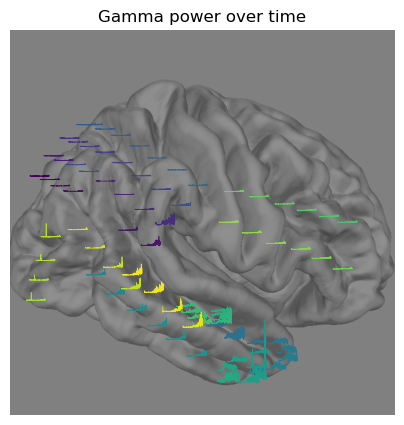

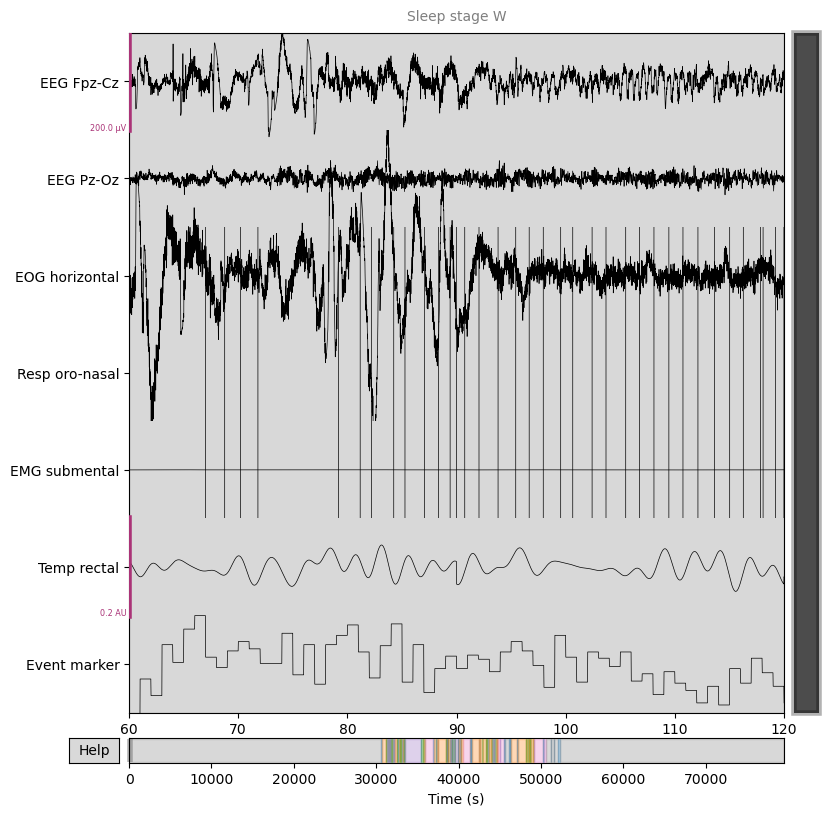

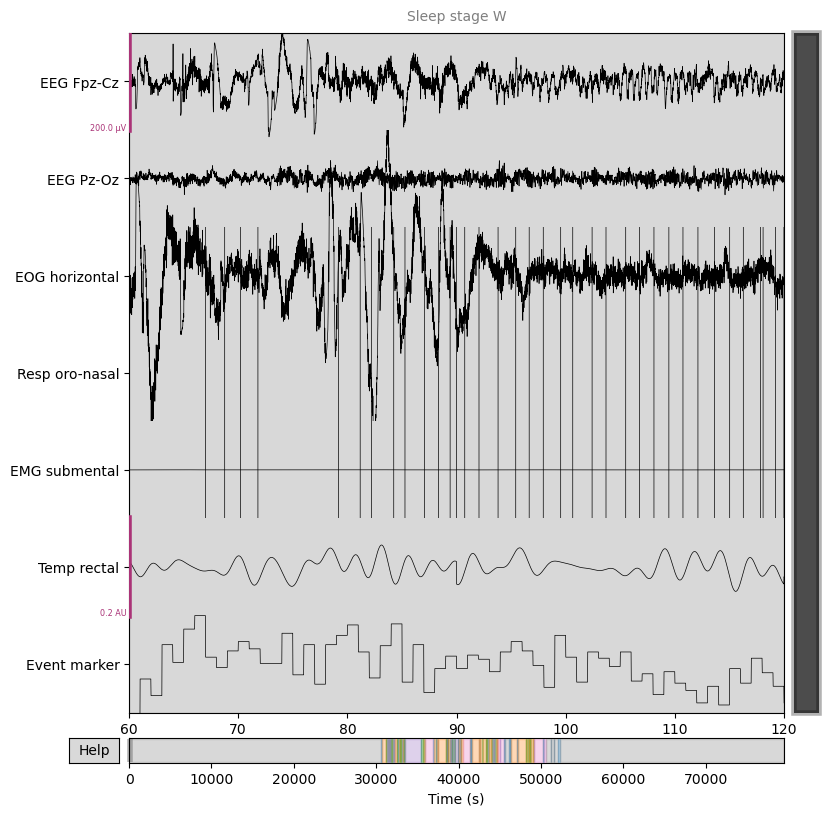

In [22]:
# read the psg data and hypnograms to create raw object

ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


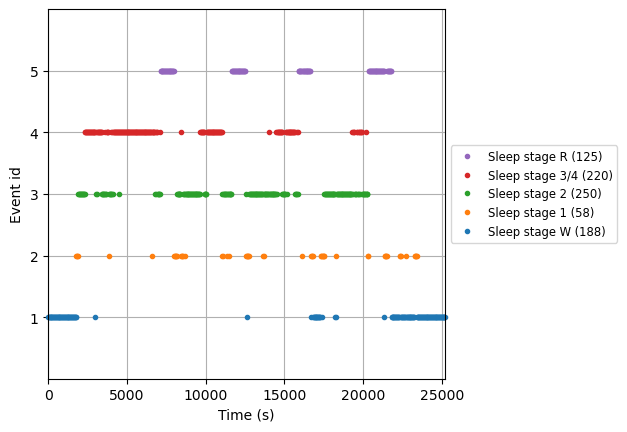

In [23]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [24]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


In [ ]:
# applying the same steps to the test data from bob

In [25]:
raw_test = mne.io.read_raw_edf(bob_files[0], stim_channel='Event marker',
                               misc=['Temp rectal'])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from /Users/DanDan/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 157
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170>


feature engineering

In [26]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.)
        spectrum.plot(ci=None, color=color, axes=ax,
                      show=False, average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax1.set(ylabel='µV²/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)

Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Av

Design a scikit-learn transformer

In [27]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    spectrum = epochs.compute_psd(picks='eeg', fmin=0.5, fmax=30.)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [28]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6727107887579329


In [29]:
# In short, yes. We can predict Bob’s sleeping stages based on Alice’s data.


In [30]:
print(confusion_matrix(y_test, y_pred))

[[155   0   0   2   0]
 [ 79   5   3   1  21]
 [ 80  19 389  24  50]
 [  0   0   4 101   0]
 [ 53   5  19   1  92]]


In [31]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.42      0.99      0.59       157
  Sleep stage 1       0.17      0.05      0.07       109
  Sleep stage 2       0.94      0.69      0.80       562
Sleep stage 3/4       0.78      0.96      0.86       105
  Sleep stage R       0.56      0.54      0.55       170

       accuracy                           0.67      1103
      macro avg       0.58      0.65      0.58      1103
   weighted avg       0.72      0.67      0.66      1103

